# Multi-class Classification with DNS data, Combined Dataset and K-Fold Cross Validation

This model will use the combined dataset and predict specific IoT devices.  The following parameters apply:

 - Using DNS
 - Dropping srcport and dstport 
 - Use categorical cross entropy




Modified version created on Google drive

In [22]:
from pathlib import Path
import os
import re
import apsw
import pandas as pd
import time

# The fun starts here...

In [23]:
cwd = Path.cwd().parent.parent
print(cwd)

/home/ricdeez/uni/projects/iotnetlearn


In [24]:
dbs = [
    os.path.join(cwd, 'db', 'db01', 'NetCollector.sqlite'),
    os.path.join(cwd, 'db', 'db02', 'NetCollector.sqlite'),
    os.path.join(cwd, 'db', 'db03', 'NetCollector.sqlite'),
]

In [25]:
from sqlalchemy import create_engine
df1 = None
df2 = None
df3 = None
for idx, db_path in enumerate(dbs):
    engine = create_engine(f'sqlite:////{db_path}')

    print(engine)

    sql = """

    select d.srcPort as srcport, 
           d.dstPort as dstport, 
           sum(d.frameSize) as totalframesize, 
           min(d.frameSize) as minframesize,
           max(d.frameSize) as maxframesize,
           avg(d.frameTTL) as framettl,
           dns.dnsquery,
           d.manufacturer,
           d.device_type
    from deviceLog d inner join dnsqueries dns on d.frameNum = dns.pktnum
    where d.device_type is not null
    group by d.srcAddr, d.dstAddr, d.srcPort, d.dstPort

    """

    if idx == 0:
        df1 = pd.read_sql_query(sql, engine)
    elif idx == 1:
        df2 = pd.read_sql_query(sql, engine)
    elif idx == 2:
        df3 = pd.read_sql_query(sql, engine)


Engine(sqlite://///home/ricdeez/uni/projects/iotnetlearn/db/db01/NetCollector.sqlite)
Engine(sqlite://///home/ricdeez/uni/projects/iotnetlearn/db/db02/NetCollector.sqlite)
Engine(sqlite://///home/ricdeez/uni/projects/iotnetlearn/db/db03/NetCollector.sqlite)


In [26]:
df1 = pd.concat([df1, df2], axis='rows', ignore_index=True)
df1 = pd.concat([df1, df3], axis='rows', ignore_index=True)
df = df1
df.describe()


,totalframesize,minframesize,maxframesize,framettl
count,32799.000000,32799.000000,32799.000000,32799.000000
mean,164.587701,84.173207,85.463063,92.856752
std,3267.692046,8.832032,9.917332,48.956212
min,65.000000,65.000000,65.000000,1.000000
25%,81.000000,78.000000,78.000000,64.000000
50%,91.000000,81.000000,81.000000,64.000000
75%,146.000000,91.000000,93.000000,128.000000
max,481258.000000,182.000000,366.000000,255.000000


In [27]:
from keras.preprocessing.text import Tokenizer
dns = df['dnsquery']

tk = Tokenizer()
tk.fit_on_texts(dns)
num_words = 200
tk.word_index = {e:i for e,i in tk.word_index.items() if i < num_words} 

encoded_dns=tk.texts_to_matrix(dns, mode='binary')
encoded_dns.shape

cols = [f'word_idx{i+1}' for i in range(num_words)]

df2 = pd.DataFrame(data=encoded_dns, columns=cols)
df = pd.concat([df, df2], axis='columns')


In [28]:
df.head()

,srcport,dstport,totalframesize,minframesize,maxframesize,framettl,dnsquery,manufacturer,device_type,word_idx1,...,word_idx191,word_idx192,word_idx193,word_idx194,word_idx195,word_idx196,word_idx197,word_idx198,word_idx199,word_idx200
0,5353,5353,13758,70,82,1.000000,_googlecast._tcp.local.,Rivet Networks,Other,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5353,5353,481258,82,132,255.000000,chromecast-audio-46eabec7bd7a728a79fb6231c4ae5...,"Google, Inc.",Chromecast-Audio,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5353,5353,1891,120,127,255.000000,_00000000-06a1-86ad-4c60-2ffbf090480e._sub._ho...,"Apple, Inc.",Apple TV,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5353,5353,882,104,190,255.000000,_sleep-proxy._udp.local.,"Apple, Inc.",Other,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5353,5353,8755,74,190,250.637931,_sleep-proxy._udp.local.,"Apple, Inc.",Other,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Skipping this bit

We will not be processing the next cell for the model with the DNS data as most
srcport and dstport entries will be either 53 or 5353.

In [29]:
"""
import numpy as np

df['is_iot'] = np.where(df['device_type'] == 'Other', 0, 1)
ports = ['53', '5353', '443', '5000', '49152', '80', '8080', '123', '49153']
features = ['dstport', 'srcport']
for feature in features:
    for port in ports:
        exec('df[\'{}_is_{}\'] = np.where(df[\'{}\'] == \'{}\', 1, 0)'.format(
                feature, port, feature, port))
"""

"\nimport numpy as np\n\ndf['is_iot'] = np.where(df['device_type'] == 'Other', 0, 1)\nports = ['53', '5353', '443', '5000', '49152', '80', '8080', '123', '49153']\nfeatures = ['dstport', 'srcport']\nfor feature in features:\n    for port in ports:\n        exec('df['{}_is_{}'] = np.where(df['{}'] == '{}', 1, 0)'.format(\n                feature, port, feature, port))\n"

In [30]:
drop_columns = ['srcport', 'dstport']
df.drop(drop_columns, axis='columns', inplace=True)

In [31]:
df.drop('dnsquery', axis='columns', inplace=True)

## Categorical Data Mapping

For the deep learning algorithm to work, we need to get rid of all categorical data.  For the Manufacturer's we will create a 1:1 mapping of the manufacturer name as per the wireshark OUI lookup dataset and the relative position of that in our ordered array of unique entries

In [32]:
mapping = {k: v for v, k in enumerate((x for x in df['manufacturer'].unique() if len(x)>0),1)}
print(mapping)

df['manufacturer'] = df['manufacturer'].map(mapping)


{'Rivet Networks': 1, 'Google, Inc.': 2, 'Apple, Inc.': 3, 'Technicolor CH USA Inc.': 4, 'Microsoft Corporation': 5, 'Intel Corporate': 6, 'Realtek Semiconductor Corp.': 7, 'Pegatron Corporation': 8, 'Ubiquiti Networks Inc.': 9, 'Sony Corporation': 10, 'ASUSTek COMPUTER INC.': 11, 'Microsoft': 12, 'Samsung Electro-Mechanics(Thailand)': 13, 'Netatmo': 14, 'Lifi Labs Management Pty Ltd': 15, 'Invoxia': 16, 'Withings': 17, 'Shenzhen Reecam Tech.Ltd.': 18, 'Belkin International Inc.': 19, 'Physical Graph Corporation': 20, 'AzureWave Technology Inc.': 21, 'Samsung Electronics Co.,Ltd': 22, 'Amazon Technologies Inc.': 23, 'HTC Corporation': 24}


## MinMax Scaling for Numerical Features

We now apply minmax scaling to each feature as per the formula below:

\begin{align}
\dot{x\tiny{i}} & = \frac{x\tiny{i} \small- min(X)}{max(X) - min(X)} \Large{\forall} \normalsize{x}\tiny{i} \small\in X
\end{align}



In [33]:
features = ['totalframesize', 'minframesize', 'maxframesize', 'framettl']
for feature in features:
    df[feature] = (df[feature] - df[feature].min()) / \
        (df[feature].max() - df[feature].min())

We will initially train the model with 10% of the data to see how well it performs.  Once we have tuned it a bit, we will repeat with the rest of the data.

In [34]:
df_sample = df #.sample(frac=0.1)
df_sample.describe()

,totalframesize,minframesize,maxframesize,framettl,manufacturer,word_idx1,word_idx2,word_idx3,word_idx4,word_idx5,...,word_idx191,word_idx192,word_idx193,word_idx194,word_idx195,word_idx196,word_idx197,word_idx198,word_idx199,word_idx200
count,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000,32799.0,32799.000000,32799.000000,32799.000000,32799.000000,...,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000,32799.000000
mean,0.000207,0.163874,0.067984,0.361641,9.795299,0.0,0.848532,0.361779,0.203817,0.203787,...,0.001494,0.001494,0.001494,0.001494,0.001494,0.001494,0.001494,0.001463,0.001463,0.001463
std,0.006791,0.075487,0.032948,0.192741,3.263756,0.0,0.358510,0.480523,0.402841,0.402818,...,0.038623,0.038623,0.038623,0.038623,0.038623,0.038623,0.038623,0.038228,0.038228,0.038228
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000033,0.111111,0.043189,0.248031,9.000000,0.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000054,0.136752,0.053156,0.248031,9.000000,0.0,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000168,0.222222,0.093023,0.500000,9.000000,0.0,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,24.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Machine learning - session 1

Firstly, we will try to see if we can converge our model, we'll split the dataset as follows:

1. Training set (80%)
2. Test set (20%)
3. We have not set up a validation set as we will continue to validate the model against new captures

The first model will be pretty basic and will only be able to `predict` if session data corresponds to an IoT device or not.

Later runs will refine the model to try to predict the device name from the data that we pass to it.  The DNN will be compriosed of the following layers:

[Input Layer: x inputs] -> [Hidden layer 1: 32 nodes] -> [Hidden layer 2: 64 nodes] -> [Hidden layer 3: 32 nodes] -> [Output layer: 1 output]

the `relu` activation function defined as f(x) = max(0, x) will be used for each layer apart from the last layer which will use the sigmoid function.  The adam optimiser will be used and the loss function will be the binary_crossentropy which is best for binary classification problems.

The Number of inputs on the Input layer is determined by the number of words that we keep for the DNS word bag


In [35]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

We drop the device_type column from the main dataframe, df to generate our set of features.  We generate labels by only indexing the device_type column.   By calling out values, we drop the headers and turn the data into numpy arrays.

In [36]:
# features = df.drop('device_type', axis=1).values
# labels = df['device_type'].values

from sklearn.model_selection import train_test_split

features = df_sample.drop('device_type', axis=1).values
labels = df_sample['device_type'].values

encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)

dummy_labels = np_utils.to_categorical(encoded_labels)
dummy_labels.shape




(32799, 24)

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(features, dummy_labels, test_size=0.2, random_state=42)
print(len(labels), len(Y_train), len(Y_test), sep='::')

32799::26239::6560


In [38]:
from itertools import count
class ModelFactory():
    _ids = count(0)

    def __init__(self):
        self.id = next(self._ids)
        self.model_idx = self.id % 5

    def get_model(self):
        model_dict = { 
            0: [128, 256, 128],
            1: [32, 64, 32],
            2: [64, 128, 64],
            3: [24, 96, 24],
            4: [16, 32, 64]
        }

        params = model_dict[self.model_idx]
        print(f'[+] Initialised with params: {params}')

        model = Sequential([
        Dense(params[0], input_dim=features.shape[1], activation='relu'),
        Dense(params[1], activation='relu'),
        Dense(params[2], activation='relu'),
        Dense(dummy_labels.shape[1], activation='softmax')
        ])
        model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=['accuracy'])
        
        return model


[+] Initialised with params: [128, 256, 128]
[+] Initialised with params: [32, 64, 32]
[+] Initialised with params: [64, 128, 64]
[+] Initialised with params: [24, 96, 24]
[+] Initialised with params: [16, 32, 64]
Loss = 0.13973890141610243, Accuracy=0.9754573106765747


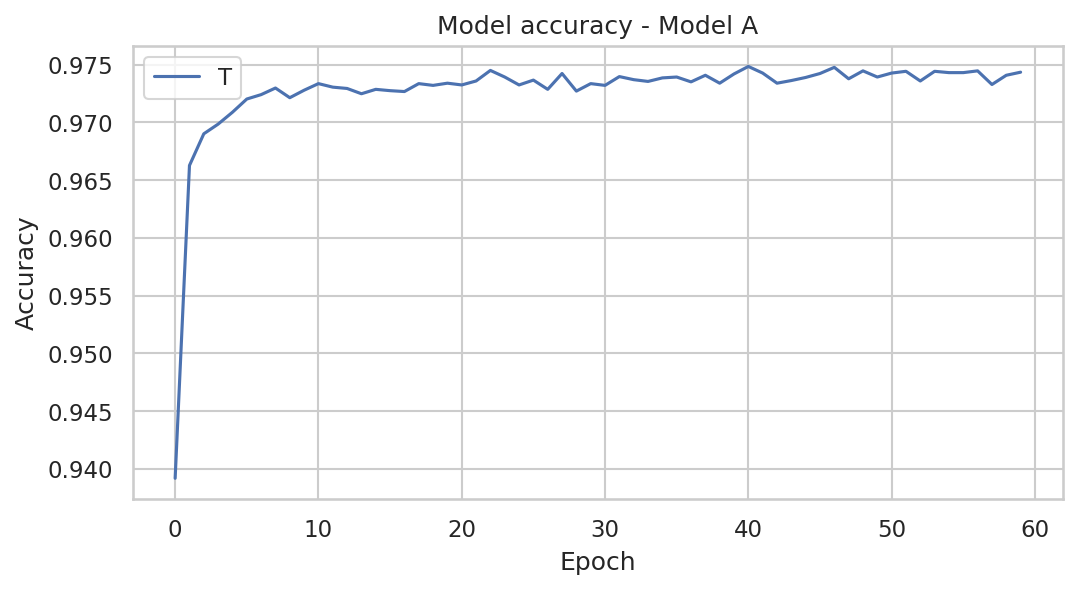

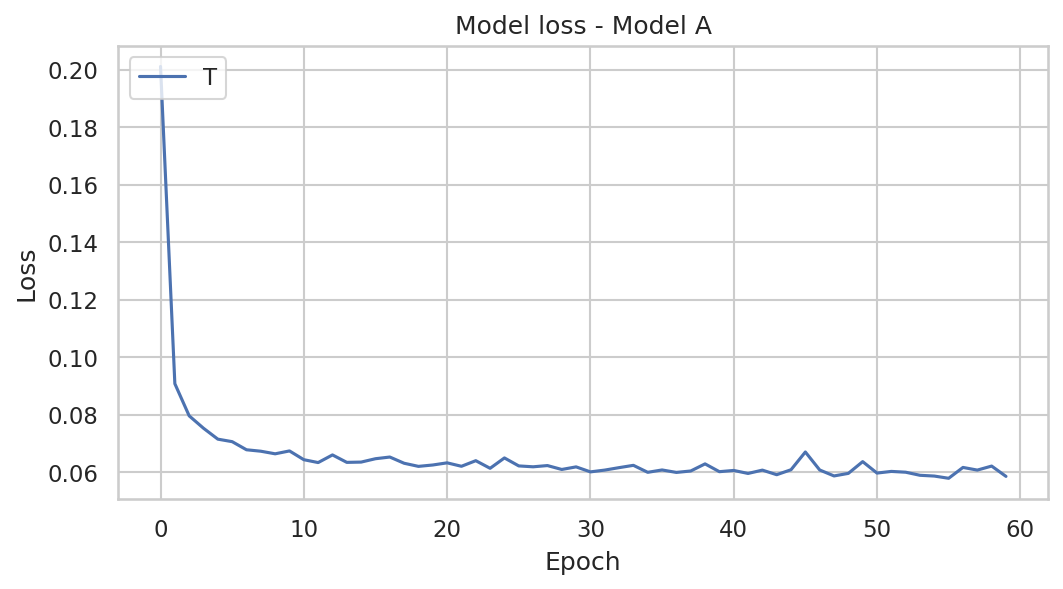

Loss = 0.095654247594754, Accuracy=0.9751524329185486


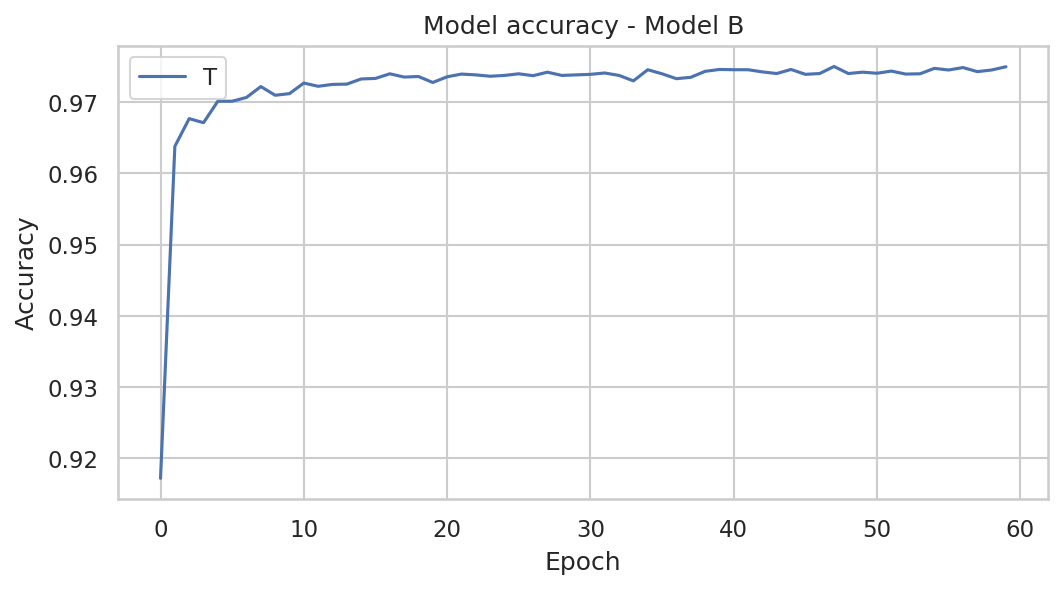

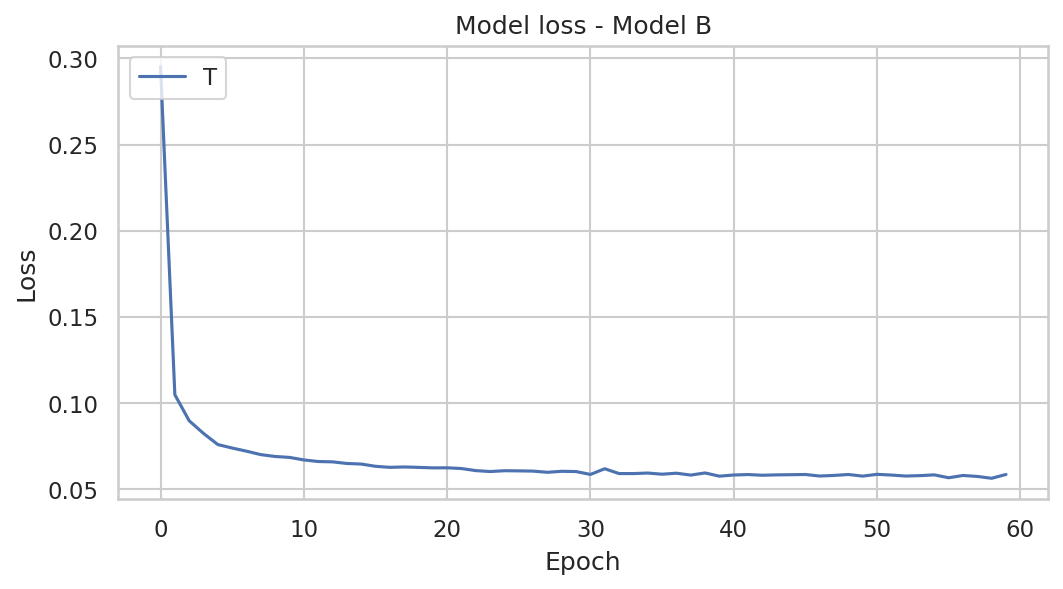

Loss = 0.12377932176294097, Accuracy=0.9765244126319885


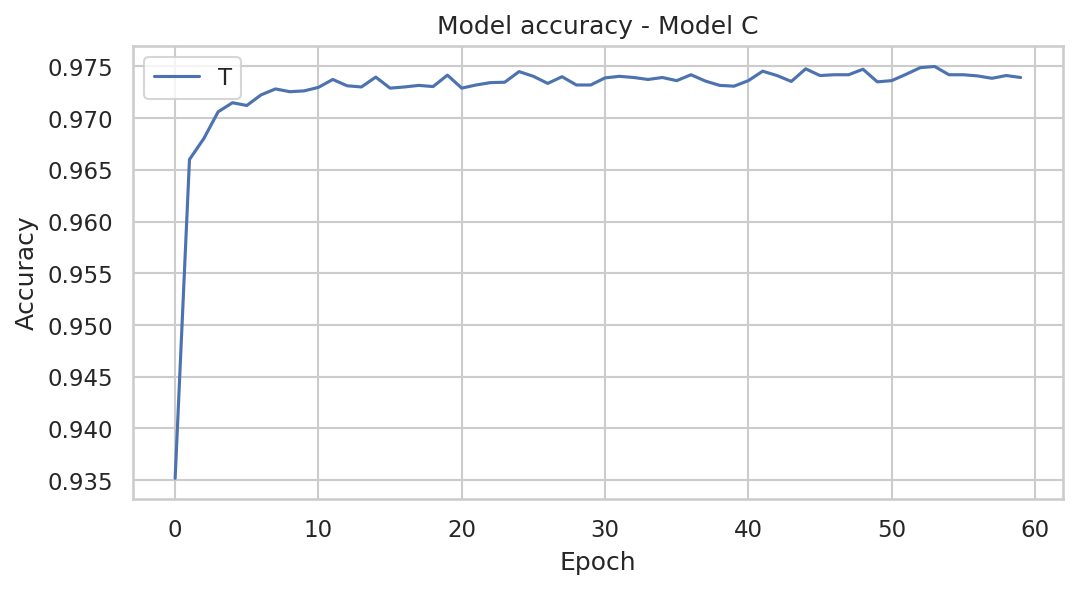

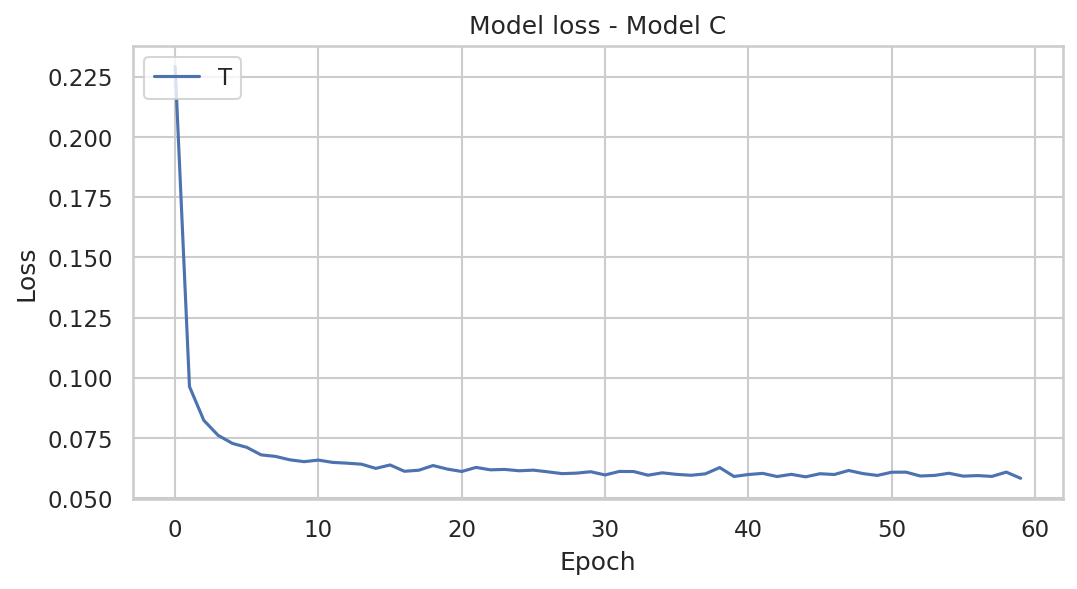

Loss = 0.08640191719890404, Accuracy=0.9748475551605225


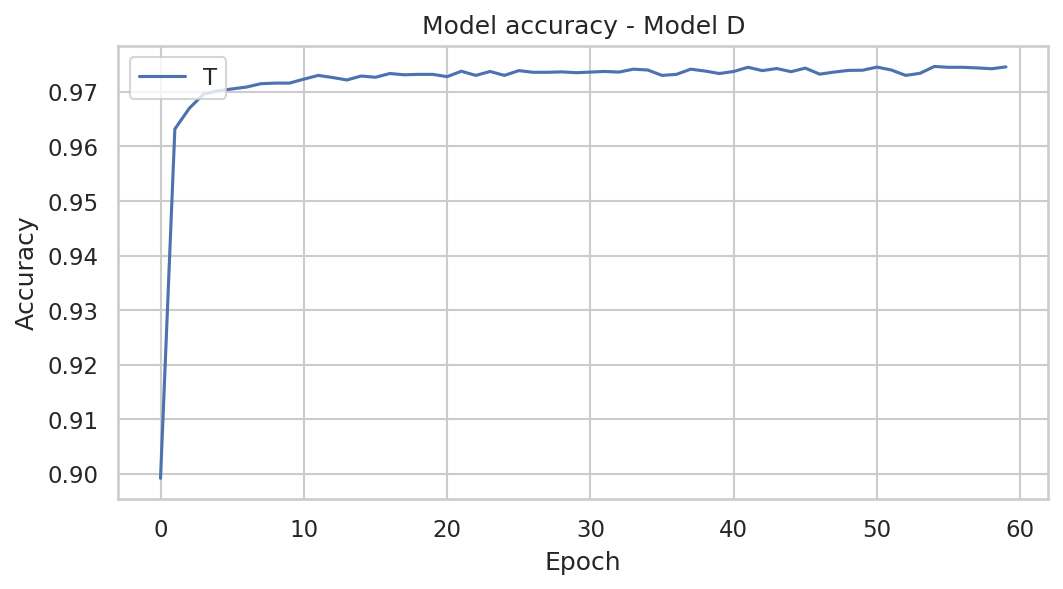

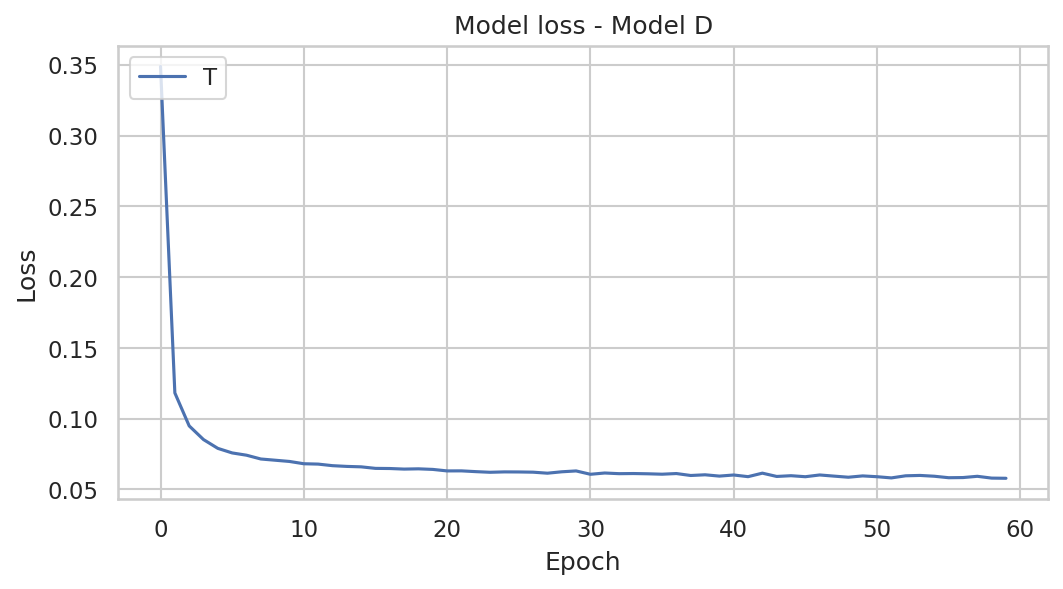

Loss = 0.08783072699093199, Accuracy=0.9754573106765747


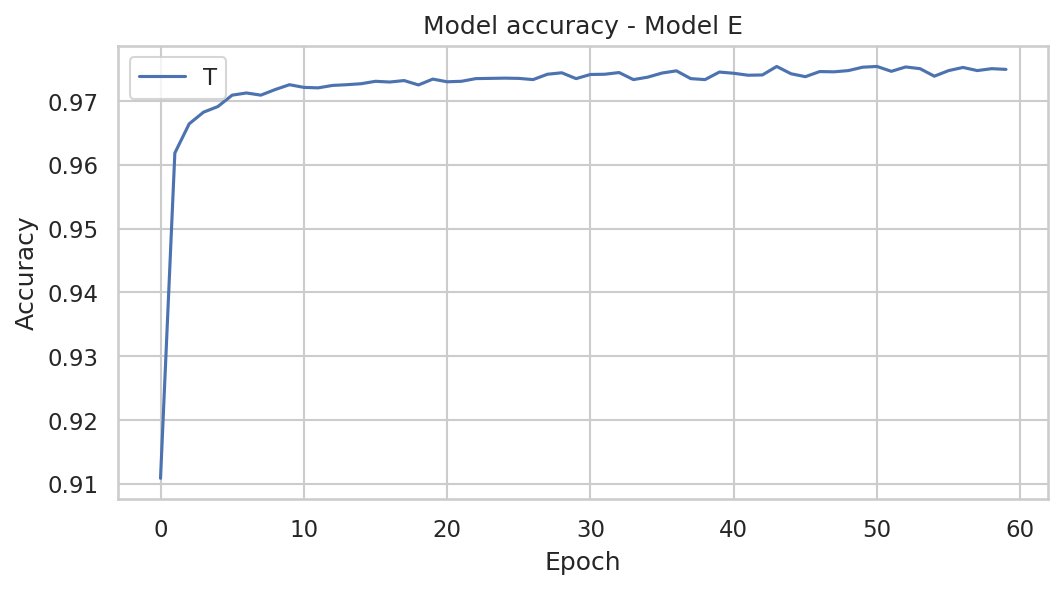

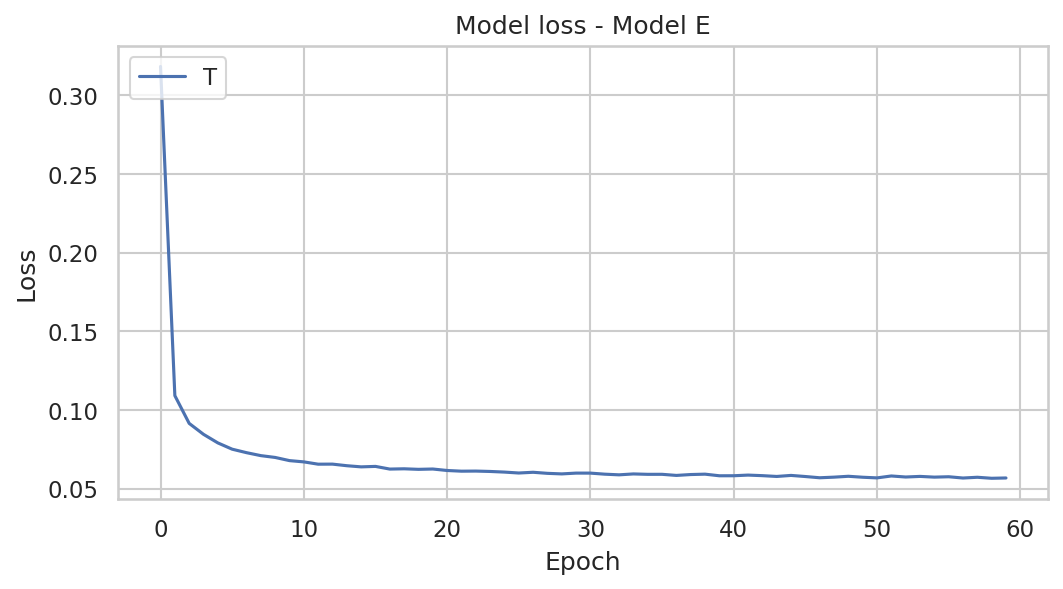

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

model_a = (ModelFactory().get_model(), 'Model A')
model_b = (ModelFactory().get_model(), 'Model B')
model_c = (ModelFactory().get_model(), 'Model C')
model_d = (ModelFactory().get_model(), 'Model D')
model_e = (ModelFactory().get_model(), 'Model E')

histories = []

for my_mod in [model_a, model_b, model_c, model_d, model_e]:
    mod = my_mod[0]
    history = mod.fit(X_train, Y_train, epochs=60, batch_size=10, shuffle=True, verbose=0)
    histories.append(history)
    loss, accuracy = mod.evaluate(X_test, Y_test, verbose=2)
    print(f'{my_mod[1]}: Loss = {loss}, Accuracy={accuracy}')
    sns.set(style="whitegrid")
    
    # Plot training & validation accuracy values
#     plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.title(f'Model accuracy - {my_mod[1]}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend('Train', loc='upper left')
    plt.show()

    # # Plot training & validation loss values
#     plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.title(f'Model loss - {my_mod[1]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend('Train', loc='upper left')
    plt.show()